In [1]:
import pandas as pd
import pickle
import umap.umap_ as umap
import hdbscan
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import silhouette_score
import sklearn.cluster as cluster
from config import OUTPUT_WITH_EMBEDDING_PICKLE_PATH, WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN, RISK_1_COLUMN, DISTIL_ROBERTA_EMBEDDING_COLUMN, MPNET_EMBEDDING_COLUMN, LEGAL_BERT_EMBEDDING_COLUMN
from data_preperation import _leave_only_main_risks

/home/amit/python_envs/nlp_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open(OUTPUT_WITH_EMBEDDING_PICKLE_PATH, "rb") as f:
    relevant_df = pickle.load(f)
relevant_df = relevant_df[[WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN, RISK_1_COLUMN, DISTIL_ROBERTA_EMBEDDING_COLUMN, LEGAL_BERT_EMBEDDING_COLUMN, MPNET_EMBEDDING_COLUMN]]

relevant_df = _leave_only_main_risks(relevant_df)
relevant_df.shape

(6602, 5)

In [3]:
print(f"Ideally we would like to have ~{len(set(relevant_df[RISK_1_COLUMN]))} clusters")

Ideally we would like to have ~26 clusters


In [4]:
relevant_df.sample(7)

why.not.ethical_clean  \
2842  If Playrix discontinues its games how is this ...   
6445  company can give data to anyone without custom...   
2337  There is no protection of data guaranteed in t...   
5876  It is unethical to expect any issues to be pos...   
6064                It removes all legal grounds to sue   
5743  It all sounds fine but the words "discuss chil...   
1534  "By continuing your use of the Project, you ar...   

                                               Risk 1  \
2842                                       no refunds   
6445                          dp&p uninformed consent   
2337                                    data security   
5876  burdens associated with using the app - general   
6064          restricting user legal action - general   
5743                              limited readability   
1534                      processing user information   

                                distilroberta_embedding  \
2842  [0.005673999, 0.06258901, -0.009170783, -0.033...   
6445  [0.027391633, -0.0032799148, -0.0043697115, -0...   
2337  [-0.00791275, 0.009099504, -0.018793542, -0.03...   
5876  [0.015911017, 0.026383359, -0.00896127, -0.061...   
6064  [-0.0072680386, 0.064606994, 0.003349254, -0.0...   
5743  [-0.014424733, 0.041849464, -0.009399052, -0.0...   
1534  [0.0008179501, -0.013674696, -0.017127313, -0....   

                                    legalbert_embedding  \
2842  [-0.040943712, 0.05437382, 0.048898716, -0.078...   
6445  [0.048158333, -0.010884556, 0.03716566, -0.154...   
2337  [-0.25635198, -0.20769808, -0.066477746, -0.00...   
5876  [-0.025629582, 0.08361242, -0.026155664, -0.04...   
6064  [-0.14277975, -0.03110117, 0.075839065, -0.081...   
5743  [-0.17374732, 0.088635586, 0.32729688, 0.22496...   
1534  [0.10309607, 0.19884588, -0.17379072, -0.03924...   

                                        mpnet_embedding  
2842  [-0.0021399958, 0.01933038, -0.010757115, 0.02...  
6445  [0.017277926, 0.083731264, -0.02891758, -0.021...  
2337  [-0.012884664, 0.09248109, -0.017271647, -0.01...  
5876  [-0.027601648, 0.102104284, -0.024508826, 0.03...  
6064  [-0.026764167, 0.058222875, 0.005814101, -0.05...  
5743  [0.05637772, 0.044942185, -0.039402783, 0.0341...  
1534  [-0.0012305846, 0.10435105, -0.0012068248, -0....

In [5]:
%%time
for embedding_column in [DISTIL_ROBERTA_EMBEDDING_COLUMN, MPNET_EMBEDDING_COLUMN]: # legalbert was very bad so we won't use it
    embeddings = list(relevant_df[embedding_column])
    algorithm = "k_means"
    for use_umap in [False]: # try False, True
        for umap_n_neighbors in [3, 15]: # try 5, 10
            for umap_dimension in [5, 20]: # try 10
                for umap_min_dist in  [0.05, 1]: # try 0.2, 0.5, 2
                    if use_umap:
                        embeddings = umap.UMAP(n_neighbors=umap_n_neighbors,
                                               n_components=umap_dimension,
                                               metric='cosine').fit_transform(embeddings)
                    else:
                        umap_n_neighbors, umap_dimension = 0, 0
                    clusters = cluster.KMeans(n_clusters=26).fit(embeddings)
                    clusters_silhouette_score = silhouette_score(embeddings, clusters.labels_)
                    relevant_df[f"clusters_{embedding_column}_algorithm_{algorithm}_umap_{umap_n_neighbors}_{umap_dimension}_{umap_min_dist}_silhouette_score_{clusters_silhouette_score}"] = clusters.labels_

    # todo: use different clustering techniques, some without umap before them
    # clusters = hdbscan.HDBSCAN(min_cluster_size=15,
    #                       metric='euclidean',
    #                       cluster_selection_method='eom').fit(embeddings) # somehow all clusters are -1. add more data
    # low n_neighbors leads to only local neighbors and ignores global neighbors, while high n_neighbors does the opposite
    # result['labels'] = clusters.labels_

    # umap_2d_embedding = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', min_cluster_size=80).fit_transform(embeddings)
    # result = pd.DataFrame(umap_2d_embedding, columns=['x', 'y'])
    # result['labels'] = clusters.labels_
Counter(clusters.labels_).most_common()

CPU times: user 14min, sys: 3min 9s, total: 17min 10s
Wall time: 1min 35s


[(3, 440),
 (13, 414),
 (19, 413),
 (10, 399),
 (12, 348),
 (5, 326),
 (20, 319),
 (16, 316),
 (1, 305),
 (6, 297),
 (25, 293),
 (23, 271),
 (15, 257),
 (2, 255),
 (14, 245),
 (24, 243),
 (17, 236),
 (8, 175),
 (7, 174),
 (11, 164),
 (18, 144),
 (22, 142),
 (4, 141),
 (9, 100),
 (0, 96),
 (21, 89)]

In [ ]:
relevant_df.sample(3)

In [ ]:
relevant_df[relevant_df[RISK_1_COLUMN] == "collection of personal data"].sample(10)

In [ ]:
relevant_df[relevant_df[RISK_1_COLUMN] == "onesided terms"].sample(10)

In [ ]:
relevant_df[relevant_df[RISK_1_COLUMN] == "dp&p uninformed consent"].sample(10)

/tmp/ipykernel_181046/4250487669.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


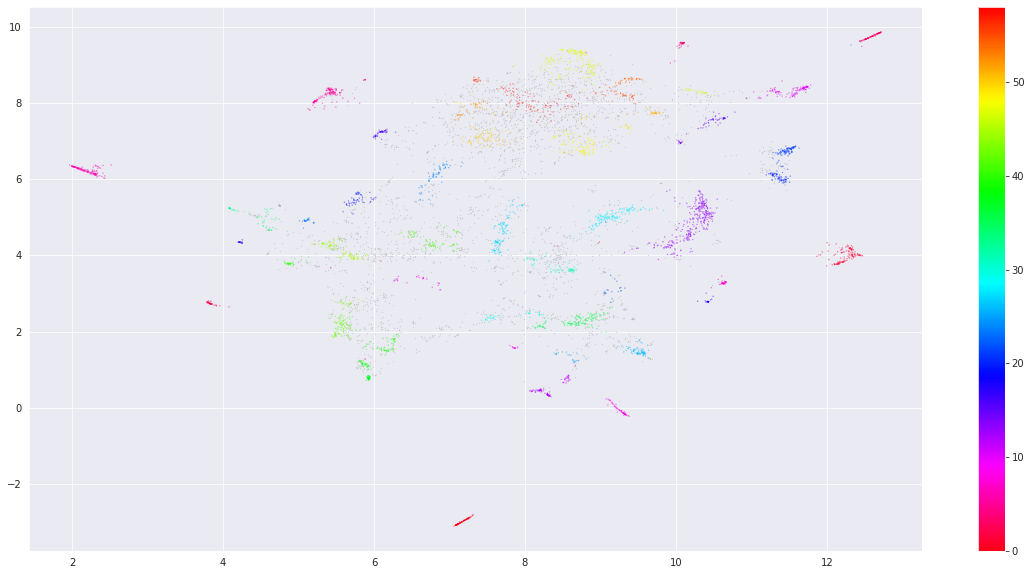

In [17]:
# Prepare data
umap_2d_embedding = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_2d_embedding, columns=['x', 'y'])
result['labels'] = clusters.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [22]:
result.sample(5)

x         y  labels
1805  9.120101  7.151499      -1
3072  9.665906  1.678823      -1
597   5.839782  1.787161      -1
2662  7.150724  7.670679      53
2616  7.763958  7.142442      -1

In [23]:
from collections import Counter
Counter(result["labels"]).most_common()

[(-1, 2914),
 (13, 325),
 (47, 193),
 (6, 144),
 (5, 139),
 (28, 137),
 (1, 132),
 (27, 124),
 (48, 115),
 (10, 113),
 (36, 109),
 (0, 98),
 (42, 97),
 (3, 95),
 (21, 91),
 (57, 81),
 (50, 76),
 (26, 76),
 (20, 75),
 (41, 73),
 (8, 69),
 (24, 68),
 (12, 65),
 (39, 58),
 (44, 53),
 (19, 50),
 (16, 49),
 (15, 48),
 (45, 46),
 (7, 45),
 (55, 44),
 (37, 43),
 (4, 43),
 (2, 42),
 (9, 38),
 (32, 38),
 (54, 36),
 (49, 35),
 (34, 33),
 (38, 33),
 (40, 31),
 (51, 31),
 (52, 30),
 (31, 29),
 (46, 26),
 (11, 25),
 (23, 24),
 (35, 24),
 (29, 24),
 (33, 23),
 (25, 23),
 (43, 22),
 (18, 21),
 (22, 19),
 (17, 19),
 (53, 19),
 (56, 19),
 (14, 18),
 (30, 17),
 (58, 15)]

In [52]:
# c-TF-IDF (clss Term Frequency Inverse Document Frequency

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    return tf_idf, count

docs_df = pd.DataFrame(relevant_df, columns=[WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN])
docs_df['Topic'] = clusters.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby('Topic', as_index = False).agg({WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN: ' '.join})

In [54]:
tf_idf, count = c_tf_idf(docs_per_topic[WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN].values, m=len(relevant_df))

In [64]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])[WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN]
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN: "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(3), topic_sizes.shape

/home/amit/python_envs/nlp_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(    Topic  Size
 0      -1  2914
 14     13   325
 48     47   193,
 (60, 2))

In [62]:
n_words_to_check = 10
topic_to_check = 1
top_n_words[topic_to_check][:n_words_to_check]

[('age', 0.20071262644409787),
 ('children', 0.1647760320169367),
 ('13', 0.11726279839058341),
 ('16', 0.08655668374893509),
 ('child', 0.07729393515683748),
 ('18', 0.07546412129377379),
 ('parent', 0.05824114568188213),
 ('parents', 0.050802621262837785),
 ('minors', 0.048537425186758486),
 ('block', 0.04032079316437994)]

In [66]:
from sklearn.metrics.pairwise import cosine_similarity

# reducing number of topics (topic reduction)
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values(WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN, ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN: ' '.join})

    # Calculate new topic words
    m = len(relevant_df)
    tf_idf, count = c_tf_idf(docs_per_topic[WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN].values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

/home/amit/python_envs/nlp_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/amit/python_envs/nlp_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/amit/python_envs/nlp_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/amit/python_envs/nlp_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87:

Topic  Size
0      -1  2978
14     13   325
34     33   193
23     22   184
26     25   169
39     38   145
7       6   144
6       5   139
11     10   139
2       1   132